In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from neighborhoods import nearest_neighborhood
from datetime import date
from dateutil.relativedelta import relativedelta



In [2]:
df = pd.read_csv('eviction_notices.csv', parse_dates=['File Date'], encoding = "ISO-8859-1")

/Users/jakram/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(df)

37736

In [4]:
df.head()

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Constraints Date,Supervisor District,Neighborhoods - Analysis Boundaries,Location
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,False,False,False,False,False,False,NaN,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)"
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,False,False,False,False,False,False,8/25/2021,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)"
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,False,False,False,False,False,False,NaN,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)"
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,False,False,False,False,False,False,NaN,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)"
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,False,False,False,False,False,False,NaN,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)"


In [5]:
df = df.dropna(subset=['Location'])
len(df)

36289

In [6]:
mindate = date(2007, 9, 15) # This is the minimum date for which we have home values from Zillow.
df = df[df['File Date'] > mindate]
len(df)


15888

In [7]:
list(df.select_dtypes(include=['bool']).columns)

['Non Payment',
 'Breach',
 'Nuisance',
 'Illegal Use',
 'Failure to Sign Renewal',
 'Access Denial',
 'Unapproved Subtenant',
 'Owner Move In',
 'Demolition',
 'Capital Improvement',
 'Substantial Rehab',
 'Ellis Act WithDrawal',
 'Condo Conversion',
 'Roommate Same Unit',
 'Other Cause',
 'Late Payments',
 'Lead Remediation',
 'Development',
 'Good Samaritan Ends']

In [8]:
# Function appends data from Zillow API and data file using neighborhood()  
def addPricingData_lookback(row, lookback):
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(','')) # Reformat lat, lng to separate arguments.
    lng = float(lng.replace(')',''))
    evictdate = row['File Date'].date() # Convert eviction date and create date keys for eviciton date and starting valuation date. 
    startdate = evictdate + relativedelta(months=-lookback)
    evictdate_key = date.strftime(evictdate,"%b%Y")
    evictdateyear = date.strftime(evictdate,"%Y")
    startdate_key = date.strftime(startdate, "%b%Y")
    neighborhood = nearest_neighborhood(lat, lng) # Create neighborhood object for lat, lng.
    name = neighborhood.name
    meanvalue = float(neighborhood.meanvalue)
    evictdatevalue = neighborhood.prices[evictdate_key]
    s = neighborhood.prices[startdate_key]
    c = neighborhood.prices[evictdate_key]
    valueincrease = (c - s)/s
    return pd.Series({'Eviction_id':row['Eviction ID'],'Lat': lat, 'Lng': lng, 'Year': evictdateyear, 'Zillow_Neighborhood':name, 'Z_2017_Value':meanvalue, 'Z_Evict_Date_Value':evictdatevalue, 'Z_Value_Increase':valueincrease}) 
    return name

def addPricingData(row):
    latlng = row['Location']
    lat, lng = latlng.split(',')
    lat = float(lat.replace('(','')) # Reformat lat, lng to separate arguments.
    lng = float(lng.replace(')',''))
    evictdate = row['File Date'].date() # Convert eviction date and create date keys for eviciton date and starting valuation date. 
    evictdate_key = date.strftime(evictdate,"%b%Y")
    evictdateyear = date.strftime(evictdate,"%Y")
    neighborhood = nearest_neighborhood(lat, lng) # Create neighborhood object for lat, lng.
    name = neighborhood.name
    meanvalue = float(neighborhood.meanvalue)
    evictdatevalue = neighborhood.prices[evictdate_key]
    return pd.Series({'Eviction_id':row['Eviction ID'],'Lat': lat, 'Lng': lng, 'Year': evictdateyear, 'Zillow_Neighborhood':name, 'Z_2017_Value':meanvalue, 'Z_Evict_Date_Value':evictdatevalue}) 
    return name



In [121]:
# This dictionary can be used to count each type of eviciton during an aggregation.
baseaggregation = {
    'Owner Move In' : {
        'total_move_in' : 'sum'
    },
    'Condo Conversion' : {
         'total_condo' : 'sum'
    },
    'Ellis Act WithDrawal' : {
         'total_ellis' : 'sum'
    },
    'Non Payment' : {
         'total_non_payment' : 'sum'
    },
    'Breach' : {
         'total_breach' : 'sum'
    },
    'Nuisance' : {
         'total_nuisance' : 'sum'
    },
    'Illegal Use' : {
         'total_illegal_use' : 'sum'
    },
    'Failure to Sign Renewal' : {
         'total_non_renewal' : 'sum'
    },
    'Access Denial' : {
         'total_access_denial' : 'sum'
    },
    'Unapproved Subtenant' : {
         'total_unapproved_subtenant' : 'sum'
    },
    'Demolition' : {
         'total_demolition' : 'sum'
    },
    'Capital Improvement' : {
         'total_capital_improvement' : 'sum'
    },
    'Substantial Rehab' : {
         'total_substantial_rehab' : 'sum'
    },
    'Roommate Same Unit' : {
         'total_roommate' : 'sum'
    },
    'Other Cause' : {
         'total_other_cause' : 'sum'
    },
    'Late Payments' : {
         'total_late_payment' : 'sum'
    },
    'Lead Remediation' : {
         'total_lead' : 'sum'
    },
    'Development' : {
         'total_development' : 'sum'
    },
    'Good Samaritan Ends' : {
         'total_total_good_samaritan' : 'sum'
    },
    'Eviction ID' : {
        'total_evictions' : 'count'
    },
    'Z_2017_Value' : {
        'current_value' : 'mean'
    },
    'Z_Evict_Date_Value' :{ 
        'eviction_date_value' : 'mean'
    }
}

# Adding a key value pair for the zillow value increase for our lookback function. 
aggregation_lookback = dict(baseaggregation)
aggregation_lookback.update({ 'Z_Value_Increase' : {'average_value_increase' : 'mean'},})

# This is the number of lookback months to find change in home values prior to an eviction.
lookbackperiod_mos = 24 

# Trimming the dataset to remove very early values that would not return values in the lookback period.
lookbackdf = df[df['File Date'] > (mindate + relativedelta(months=+lookbackperiod_mos)) ]

# Merge the results of our calls to neighborhood() back to our dataframe.
lookbackdf = lookbackdf.merge(lookbackdf.apply(lambda row: addPricingData_lookback(row, lookbackperiod_mos), axis = 1), left_on='Eviction ID', right_on='Eviction_id')

# Creating a dataframe to group by neighborhood. 
groupby_hood = lookbackdf.groupby([('Zillow_Neighborhood')],as_index=True).agg(aggregation_lookback).reset_index()

# Creating a row-wise sum of all the non-cause eviciton counts.
groupby_hood[('total_non_cause','total_non_cause')] = groupby_hood[[
                                               ('Owner Move In', 'total_move_in'),
                                               ('Condo Conversion', 'total_condo'),
                                               ('Ellis Act WithDrawal', 'total_ellis'),
                                               ('Substantial Rehab', 'total_substantial_rehab'),
                                               ('Lead Remediation', 'total_lead'),
                                               ('Development', 'total_development') 
                                               ]].sum(axis=1)

# Adding a column to show the frequency of non-cause evicitons.
groupby_hood[('non_cause_frequency','non_cause_frequency')] = (groupby_hood[('total_non_cause','total_non_cause')]/
                                                               groupby_hood[('Eviction ID','total_evictions')]
                                                              )

# Drop rows for neighborhoods without pricing data.
groupby_hood = groupby_hood.dropna(subset=[('Z_Value_Increase', 'average_value_increase')]).reset_index()

# Drop neighborhoods with small sample sizes.
groupby_hood = groupby_hood[groupby_hood[('Eviction ID', 'total_evictions')] > 40]

groupby_hood.head()


,index,Zillow_Neighborhood,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Non Payment,Breach,Nuisance,Illegal Use,Failure to Sign Renewal,...,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,Z_Value_Increase,total_non_cause,non_cause_frequency
,,,total_move_in,total_condo,total_ellis,total_non_payment,total_breach,total_nuisance,total_illegal_use,total_non_renewal,...,total_late_payment,total_lead,total_development,total_total_good_samaritan,total_evictions,current_value,eviction_date_value,average_value_increase,total_non_cause,non_cause_frequency
0,3,Bayview,35.0,0.0,6.0,58.0,77.0,54.0,8.0,3.0,...,19.0,False,0.0,0.0,292,612400.0,6.195523e+05,0.355382,41.0,0.140411
1,4,Bernal Heights,102.0,7.0,67.0,20.0,99.0,62.0,8.0,0.0,...,14.0,False,1.0,3.0,448,1083700.0,9.750016e+05,0.183775,183.0,0.408482
2,5,Buena Vista Park,13.0,0.0,14.0,6.0,20.0,12.0,1.0,2.0,...,6.0,False,0.0,0.0,111,1304100.0,1.148954e+06,0.143660,27.0,0.243243
3,6,Central Richmond,67.0,2.0,30.0,16.0,71.0,54.0,8.0,0.0,...,18.0,False,0.0,0.0,272,1284800.0,1.172776e+06,0.212858,99.0,0.363971
4,7,Central Sunset,75.0,0.0,22.0,10.0,28.0,37.0,3.0,0.0,...,9.0,False,0.0,0.0,212,994300.0,9.747415e+05,0.170994,97.0,0.457547


In [96]:
pricingdf = df.merge(df.apply(addPricingData, axis=1), left_on='Eviction ID', right_on='Eviction_id')
pricingdf

,Eviction ID,Address,City,State,Eviction Notice Source Zipcode,File Date,Non Payment,Breach,Nuisance,Illegal Use,...,Supervisor District,Neighborhoods - Analysis Boundaries,Location,Eviction_id,Lat,Lng,Year,Z_2017_Value,Z_Evict_Date_Value,Zillow_Neighborhood
0,M161957,300 Block Of Park Street,San Francisco,CA,94110,2016-06-06,False,False,False,False,...,9.0,Bernal Heights,"(37.7364374645373, -122.417989910582)",M161957,37.736437,-122.417990,2016,1083700.0,1193000.0,Bernal Heights
1,M162256,200 Block Of Seneca Avenue,San Francisco,CA,94112,2016-06-29,False,False,False,False,...,11.0,Outer Mission,"(37.7205429316262, -122.443264852669)",M162256,37.720543,-122.443265,2016,814200.0,951300.0,Mission Terrace
2,M162135,200 Block Of Dolores Street,San Francisco,CA,94103,2016-06-28,False,True,False,False,...,8.0,Castro/Upper Market,"(37.7652067507312, -122.426591617441)",M162135,37.765207,-122.426592,2016,0.0,NaN,Duboce Triangle
3,M161901,1200 Block Of 9th Avenue,San Francisco,CA,94122,2016-06-02,False,False,False,False,...,5.0,Inner Sunset,"(37.764977785911, -122.4664456379)",M161901,37.764978,-122.466446,2016,1154400.0,1362400.0,Inner Sunset
4,M162428,1400 Block Of Larkin Street,San Francisco,CA,94109,2016-02-28,False,False,False,False,...,3.0,Nob Hill,"(37.7912373166567, -122.419197310472)",M162428,37.791237,-122.419197,2016,1192900.0,1461900.0,Nob Hill
5,M161943,300 Block Of Wilde Avenue,San Francisco,CA,94134,2016-06-06,False,False,True,False,...,10.0,Visitacion Valley,"(37.7167969475402, -122.403664398767)",M161943,37.716797,-122.403664,2016,689000.0,743500.0,Little Hollywood
6,M161986,0 Block Of Fair Avenue,San Francisco,CA,94110,2016-06-13,False,True,False,False,...,9.0,Bernal Heights,"(37.7453025419492, -122.419008184627)",M161986,37.745303,-122.419008,2016,1083700.0,1193000.0,Bernal Heights
7,M161976,1300 Block Of Market Street,San Francisco,CA,94102,2016-06-13,True,False,False,False,...,6.0,Tenderloin,"(37.777083463941, -122.416979326588)",M161976,37.777083,-122.416979,2016,713000.0,812300.0,Van Ness - Civic Center
8,M162257,300 Block Of Lombard Street,San Francisco,CA,94133,2016-06-30,False,False,False,False,...,3.0,North Beach,"(37.8035109665788, -122.407095028398)",M162257,37.803511,-122.407095,2016,852000.0,952100.0,North Waterfront
9,M161838,2800 Block Of Pierce Street,San Francisco,CA,94123,2016-06-01,False,False,False,False,...,2.0,Marina,"(37.7961971224445, -122.438753767562)",M161838,37.796197,-122.438754,2016,1732300.0,2104800.0,Cow Hollow


In [123]:
# Creating a dataframe to group by year, then neighborhood. 
groupby_year_hood = pricingdf.groupby(['Zillow_Neighborhood', 'Year']).agg(baseaggregation).reset_index()

# Drop neighborhoods that lack Zillow pricing data.
groupby_year_hood = groupby_year_hood.dropna(subset=[('Z_2017_Value', 'current_value')]).reset_index()

# Creating a row-wise sum of all the non-cause eviciton counts.
groupby_year_hood[('total_non_cause','total_non_cause')] = groupby_year_hood[[
                                               ('Owner Move In', 'total_move_in'),
                                               ('Condo Conversion', 'total_condo'),
                                               ('Ellis Act WithDrawal', 'total_ellis'),
                                               ('Substantial Rehab', 'total_substantial_rehab'),
                                               ('Lead Remediation', 'total_lead'),
                                               ('Development', 'total_development') 
                                               ]].sum(axis=1)

groupby_year_hood.head()

,index,Zillow_Neighborhood,Year,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Non Payment,Breach,Nuisance,Illegal Use,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,total_non_cause
,,,,total_move_in,total_condo,total_ellis,total_non_payment,total_breach,total_nuisance,total_illegal_use,...,total_roommate,total_other_cause,total_late_payment,total_lead,total_development,total_total_good_samaritan,total_evictions,current_value,eviction_date_value,total_non_cause
0,0,Alamo Square,2007,1.0,0.0,10.0,2.0,9.0,3.0,1.0,...,1.0,2.0,3.0,False,0.0,0.0,31,0.0,NaN,11.0
1,1,Alamo Square,2008,3.0,0.0,1.0,5.0,23.0,3.0,0.0,...,1.0,1.0,5.0,False,0.0,0.0,43,0.0,NaN,4.0
2,2,Alamo Square,2009,3.0,0.0,1.0,0.0,10.0,4.0,0.0,...,1.0,1.0,1.0,False,0.0,0.0,23,0.0,NaN,4.0
3,3,Alamo Square,2010,1.0,0.0,0.0,3.0,3.0,10.0,0.0,...,1.0,0.0,0.0,False,0.0,0.0,19,0.0,NaN,1.0
4,4,Alamo Square,2011,3.0,0.0,0.0,6.0,5.0,3.0,0.0,...,0.0,0.0,2.0,False,0.0,0.0,19,0.0,NaN,4.0


In [125]:
# Creating a dataframe to group by year, then neighborhood. 
groupby_year = pricingdf.groupby(['Year']).agg(baseaggregation).reset_index()

# Drop neighborhoods that lack Zillow pricing data.
groupby_year = groupby_year.dropna(subset=[('Z_2017_Value', 'current_value')]).reset_index()

# Creating a row-wise sum of all the non-cause eviciton counts.
groupby_year[('total_non_cause','total_non_cause')] = groupby_year[[
                                               ('Owner Move In', 'total_move_in'),
                                               ('Condo Conversion', 'total_condo'),
                                               ('Ellis Act WithDrawal', 'total_ellis'),
                                               ('Substantial Rehab', 'total_substantial_rehab'),
                                               ('Lead Remediation', 'total_lead'),
                                               ('Development', 'total_development') 
                                               ]].sum(axis=1)

groupby_year.head()

,index,Year,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Non Payment,Breach,Nuisance,Illegal Use,Failure to Sign Renewal,...,Roommate Same Unit,Other Cause,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,total_non_cause
,,,total_move_in,total_condo,total_ellis,total_non_payment,total_breach,total_nuisance,total_illegal_use,total_non_renewal,...,total_roommate,total_other_cause,total_late_payment,total_lead,total_development,total_total_good_samaritan,total_evictions,current_value,eviction_date_value,total_non_cause
0,0,2007,43.0,0.0,86.0,33.0,140.0,77.0,8.0,4.0,...,4.0,9.0,26.0,1.0,0.0,0.0,457,9.273363e+05,887001.201201,130.0
1,1,2008,165.0,2.0,192.0,101.0,370.0,316.0,44.0,2.0,...,26.0,52.0,80.0,0.0,0.0,0.0,1385,1.004217e+06,878412.830957,359.0
2,2,2009,113.0,2.0,48.0,111.0,399.0,256.0,36.0,6.0,...,25.0,59.0,78.0,3.0,0.0,0.0,1146,9.362609e+05,727824.477958,166.0
3,3,2010,117.0,4.0,68.0,80.0,435.0,289.0,19.0,9.0,...,33.0,72.0,52.0,0.0,106.0,0.0,1322,7.755082e+05,765621.496437,295.0
4,4,2011,124.0,2.0,54.0,88.0,522.0,234.0,28.0,4.0,...,28.0,57.0,46.0,0.0,0.0,0.0,1265,8.841570e+05,768292.812500,181.0


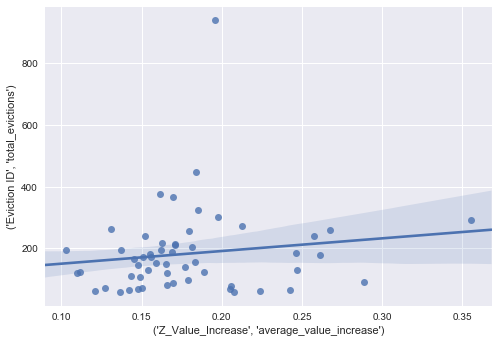

In [99]:
ax = sns.regplot(y=groupby_hood[('Eviction ID', 'total_evictions')], x=groupby_hood[('Z_Value_Increase', 'average_value_increase')], data=groupby_hood)
plt.show()

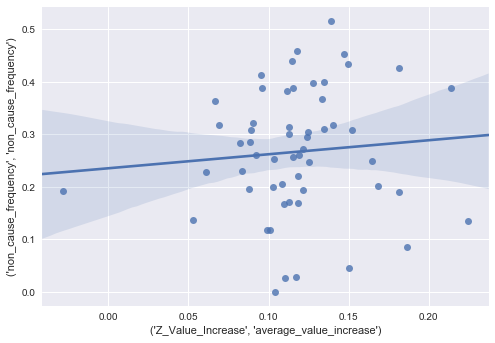

In [94]:
ax = sns.regplot(y=groupby_hood[('non_cause_frequency','non_cause_frequency')], x=groupby_hood[('Z_Value_Increase', 'average_value_increase')], data=groupby_hood)
plt.show()

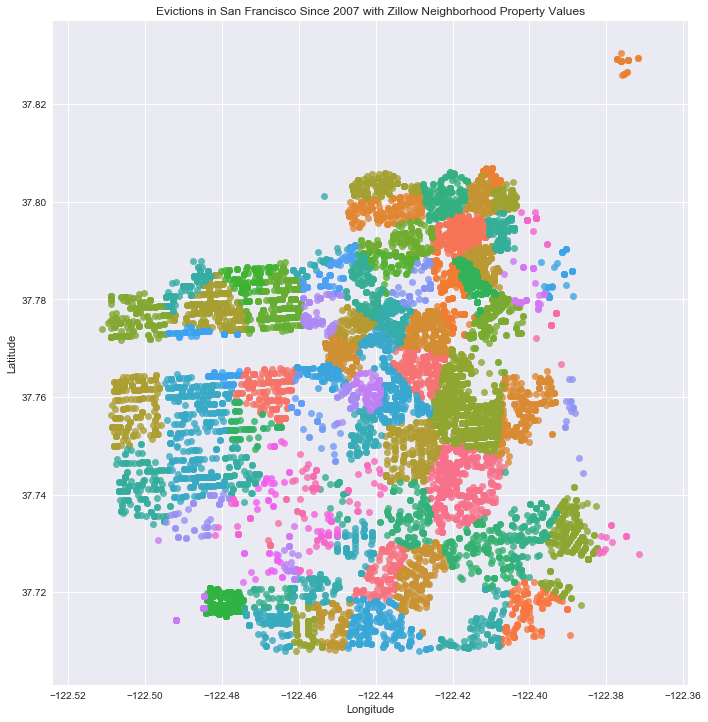

In [100]:
ax = sns.lmplot(x='Lng', y='Lat', hue='Zillow_Neighborhood', size=10, data=pricingdf, fit_reg=False, legend=False)
ax.despine(left=True)

# Set title, x-axis label, y-axis label.
plt.title('Evictions in San Francisco Since 2007 with Zillow Neighborhood Property Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [124]:
groupby_hood_lmplot = groupby_hood.sort_values(by=('Z_Value_Increase', 'average_value_increase'))
groupby_hood_lmplot.columns = groupby_hood_lmplot.columns.droplevel(level=1)
groupby_hood_lmplot.head()

,index,Zillow_Neighborhood,Owner Move In,Condo Conversion,Ellis Act WithDrawal,Non Payment,Breach,Nuisance,Illegal Use,Failure to Sign Renewal,...,Late Payments,Lead Remediation,Development,Good Samaritan Ends,Eviction ID,Z_2017_Value,Z_Evict_Date_Value,Z_Value_Increase,total_non_cause,non_cause_frequency
7,12,Cow Hollow,34.0,5.0,15.0,11.0,56.0,45.0,10.0,0.0,...,10.0,False,0.0,0.0,194,1732300.0,1.518113e+06,0.102614,54.0,0.278351
59,72,Silver Terrace,26.0,0.0,2.0,13.0,25.0,24.0,2.0,1.0,...,6.0,False,0.0,0.0,121,613400.0,6.261702e+05,0.109935,28.0,0.231405
64,80,Twin Peaks,21.0,0.0,8.0,3.0,44.0,39.0,5.0,0.0,...,10.0,False,0.0,0.0,124,1136900.0,9.240645e+05,0.111455,29.0,0.233871
27,35,Jordan Park - Laurel Heights,17.0,0.0,4.0,1.0,13.0,15.0,0.0,0.0,...,4.0,False,0.0,0.0,63,2144800.0,1.813521e+06,0.120604,21.0,0.333333
35,43,Merced Heights,9.0,0.0,2.0,2.0,42.0,3.0,1.0,0.0,...,3.0,False,0.0,0.0,70,755900.0,6.960414e+05,0.126904,11.0,0.157143


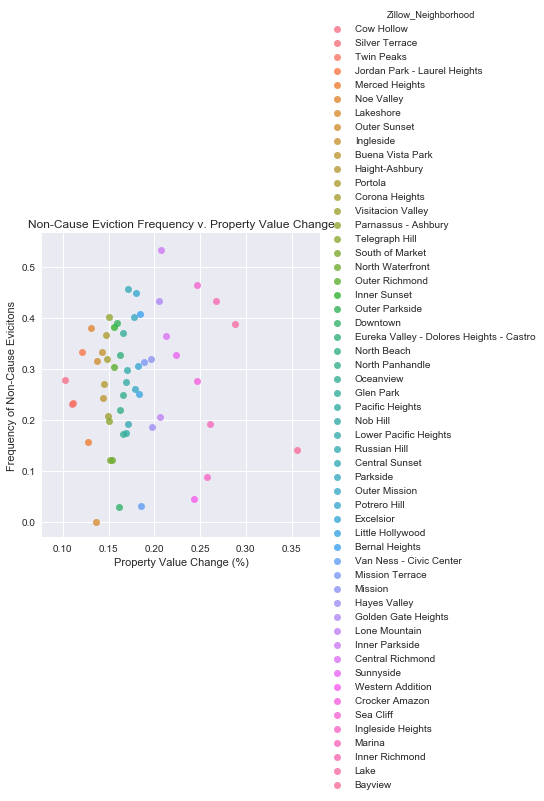

In [120]:


# Set style of scatterplot
sns.set(style="darkgrid")

# Set markers
# markers = ['o','_','x']*18

# Create scatterplot of non-cause eviciton frequency with property value increase.
sns.lmplot('Z_Value_Increase', # Horizontal axis
          'non_cause_frequency', # Vertical axis
          data = groupby_hood_lmplot, # Data source
          fit_reg = False, # Don't fix a regression line
          hue = 'Zillow_Neighborhood', # Set color
#           markers = markers
          )

# Set title, x-axis label, y-axis label.
plt.title('Non-Cause Eviction Frequency v. Property Value Change')
plt.xlabel('Property Value Change (%)')
plt.ylabel('Frequency of Non-Cause Evicitons')

plt.show()

In [ ]:
ax = sns.barplot(x='Zillow_Neighborhood', y='pct_suspect', data=groupby_hood)
ax.set_xticklabels(labels=groupby_hood['Zillow_Neighborhood'], rotation=90)
plt.show()